Look back if not sure (about the exp setting): hyp.yaml and opt.yaml

sound results:
- 191. The baseline. fine tune 5 and fl (1.5/0.75). 450 epoch (NOT THE BASE)
- 192. The pretrain baseline 150, then cyolo 300. fine tune 5 and fl (1.5/0.75). 
- 

Plotting for 191 

In [166]:
import os
import pandas as pd
import json
import yaml
from utils.plots import plot_images
from utils.datasets import create_dataloader
from train_with_bcc import get_file_volunteers_dict
from train_with_bcc import VOL_ID_MAP as vol_id_map

from IPython.display import Image
from itertools import product


import numpy as np
import torch

from shutil import copyfile, rmtree
from pathlib import Path


In [167]:
rel_path = os.path.join(os.curdir, 'runs', 'train')

In [168]:
def read_exp_results(exp_no, exp_prefix='exp'):
    exp_prefix = 'exp'
    exp_name = f'{exp_prefix}{exp_no}'
    exp_path = os.path.join(rel_path, exp_name)
    res_file_name = os.path.join(exp_path, 'results.csv')
    results_df = pd.read_csv(res_file_name)
    pred = json.load(open(os.path.join(exp_path, '_predictions.json'))) #todo
    hyp = yaml.safe_load(open(os.path.join(exp_path, 'hyp.yaml'))) #todo
    opt = yaml.safe_load(open(os.path.join(exp_path, 'opt.yaml'))) #todo
    return {'results': results_df, 'hyp': hyp, 'opt': opt, 'pred': pred}

def get_im_vol_list(target_volunteers, num_images):
    im_vol_list = []
    for i in range(num_images):
        x = target_volunteers[target_volunteers[:,0] == i, -1].int().detach().numpy()
        num_boxes = x.shape[0]
        vol_per_im = []
        for j in range(num_boxes):
            vol_per_im.append(x[j])
        im_vol_list.append(vol_per_im)
    return im_vol_list

In [169]:
img_info_map = {'imgs': None,
                'volunteer_labels': None,
                'expert_labels': None,
                'yolo_labels': None,
                'cyolo_labels': None}

In [170]:
yolo_exp_id = 194
yolo_results = read_exp_results(yolo_exp_id)
yolo_results, yolo_hyp, yolo_opt, yolo_pred = [yolo_results[x] for x in ['results', 'hyp', 'opt', 'pred']]

cyolo_exp_id = 196
cyolo_results = read_exp_results(cyolo_exp_id)
cyolo_results, cyolo_hyp, cyolo_opt, cyolo_pred = [cyolo_results[x] for x in ['results', 'hyp', 'opt', 'pred']]

In [175]:
data_dict = yaml.safe_load(open(cyolo_opt['data']))
val_path = os.path.join(data_dict['path'], data_dict['val'])
imgsz = cyolo_opt['imgsz']
batch_size = 20

In [177]:
volunteers_loader, volunteers_dataset = create_dataloader(val_path, imgsz, batch_size, 32, hyp=cyolo_hyp, augment=False)
file_volunteers_dict = get_file_volunteers_dict(data_dict, mode='val', vol_id_map = vol_id_map)

temp_data_name = 'temp'
data_home, data_name = data_dict['path'].split('/')
user = 'Jonathan'

temp_dir = os.path.join(data_home, temp_data_name)
temp_la_dir = os.path.join(temp_dir, 'labels')
temp_im_dir = os.path.join(temp_dir, 'images')
Path(temp_la_dir).mkdir(parents=True, exist_ok=True)
Path(temp_im_dir).mkdir(parents=True, exist_ok=True)

for f in volunteers_dataset.label_files:
    la_name = f.split(os.sep)[-1]
    im_name = la_name.split('.')[0]+'.jpg'
    la_path = os.path.join(data_home, 'master', 'labels', user, la_name)
    im_path = os.path.join(data_home, 'master', 'images', im_name)
    temp_la_path = os.path.join(temp_la_dir, la_name)
    temp_im_path = os.path.join(temp_im_dir, im_name)
#     h, w, _ = cv2.imread('data/src/lena.jpg').shape
    copyfile(la_path, temp_la_path)
    copyfile(im_path, temp_im_path)

expert_loader, expert_dataset = create_dataloader(temp_im_dir, imgsz, batch_size, 32, hyp=cyolo_hyp, augment=False)

for i, (vol, exp) in enumerate(zip(volunteers_loader, expert_loader)):
    imgs, vol_targets, _, _ = vol
    _, exp_targets, _, _ = exp
    img_info_map['imgs'] = imgs
    img_info_map['volunteer_labels'] = vol_targets
    img_info_map['expert_labels'] = exp_targets
    break

Scanning 'datasets\bcc-tvt\labels\val.cache' images and labels... 20 found, 0 missing, 3 empty, 0 corrupted: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<?, ?it/s]
Scanning 'datasets\temp\labels' images and labels...20 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.51it/s]


In [178]:
rmtree(temp_dir)

In [179]:
im_id_map = {x.split(os.sep)[-1].split('.')[0]: i for i, x in enumerate(volunteers_dataset.label_files)}

In [202]:
im_wh_map = {x.split(os.sep)[-1].split('.')[0]: wh for i, (x, wh) in enumerate(zip(volunteers_dataset.label_files, volunteers_dataset.shapes))}

In [203]:
im_wh_map

{'IS20191125_105634_0062_000039C9': array([        941,         724]),
 'IX20191030_093817_0791_000037B5': array([        938,         703]),
 'Unknown-X-20191111-111540-XE2TAIKRCCFW-3': array([       1932,        1492]),
 'Unknown-X-20191119-084034-XKT545WVTDVB-3': array([       1925,        1489]),
 'Unknown-X-20191204-104701-X8TERKZGTGBV-3': array([       1924,        1479]),
 'Unknown-X-20191217-084358-XQKK52WLJONL-3': array([       1926,        1487]),
 'Unknown-X-20191220-105600-XL4G9IEHA2XS-3': array([       1937,        1496]),
 'Unknown-X-20200108-120416-XDI5AZK8EAY1-3': array([       1944,        1519]),
 'Unknown-X-20200108-162424-XJTVFFN98KRL-3': array([       1936,        1499]),
 'Unknown-X-20200206-103145-XGYENCEPQD41-3': array([       1614,        1242]),
 'Unknown-X-20200128-125352-XHUIDRHZZXXF-3': array([       1610,        1242]),
 'Unknown-X-20200207-095434-XYJSEIZ0GUDU-3': array([       1616,        1240]),
 'Unknown-X-20200207-111448-XMFGZGHVZXBO-3': array([      

In [205]:
def create_targets(x):
    im_name = x['image_id'].split('.')[0]
    im_id = im_id_map[im_name]
    cat_id = x['category_id']
    score = x['score']
    bb_x, bb_y, bb_w, bb_h = x['bbox']
    w, h = im_wh_map[im_name]
    normalized_bbox = [bb_x*1.0/w, bb_y*1.0/h, bb_w*1.0/w, bb_h*1.0/h]
    target = [im_id, cat_id] + normalized_bbox + [score]
    return target

conf_thres = 0.25
df_pred = pd.DataFrame(yolo_pred)
df_pred = df_pred[df_pred['score'] > conf_thres]
pred_targets = torch.tensor(list(df_pred.apply(create_targets, axis=1)))
img_info_map['yolo_labels'] = pred_targets

df_pred = pd.DataFrame(cyolo_pred)
df_pred = df_pred[df_pred['score'] > conf_thres]
pred_targets = torch.tensor(list(df_pred.apply(create_targets, axis=1)))
img_info_map['cyolo_labels'] = pred_targets

## Volunteer labels

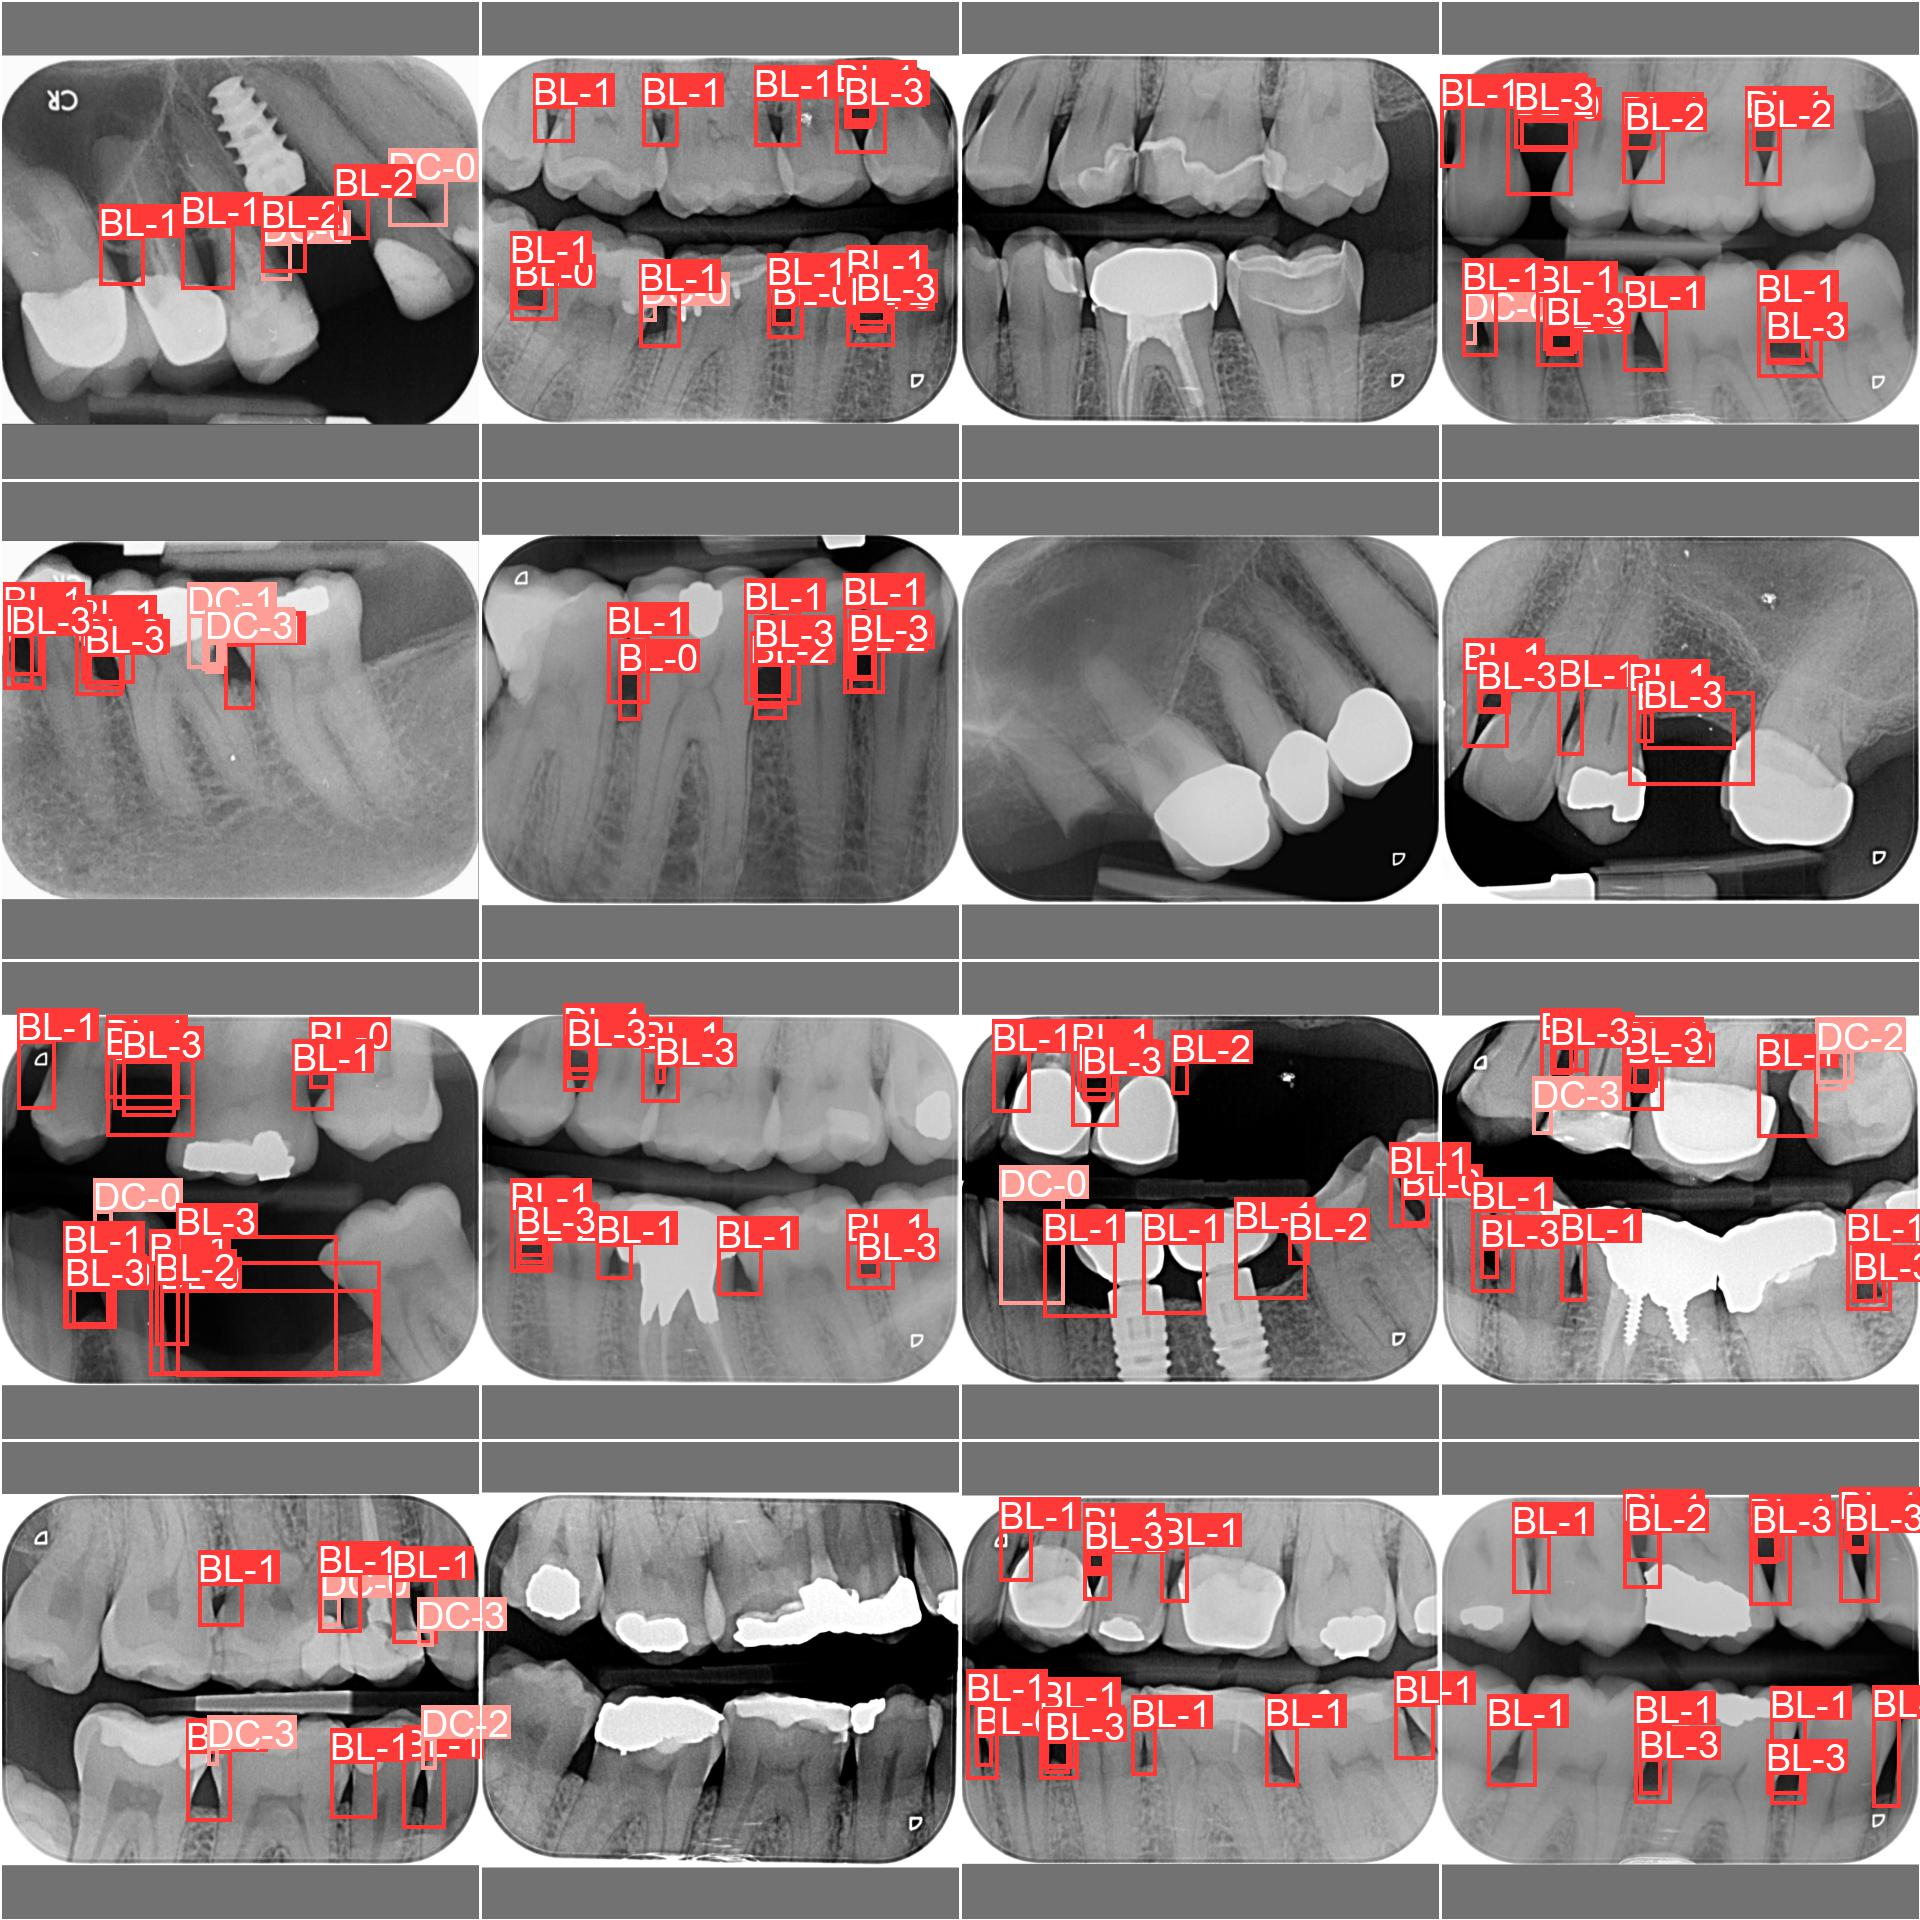

In [181]:
num_cl = 2
num_vol = 4
class_name = {0: 'BL', 1: 'DC'}

batch_filenames = [volunteers_dataset.label_files[x].split(os.sep)[-1] for x in np.where(volunteers_dataset.batch==i)[0]]
batch_volunteers_list = [file_volunteers_dict[fn] for fn in batch_filenames]
batch_volunteers = torch.cat(batch_volunteers_list)
target_volunteers = torch.cat([img_info_map['volunteer_labels'], batch_volunteers.unsqueeze(-1)], axis=1)
im_vol_list = get_im_vol_list(target_volunteers, imgs.shape[0])
plot_images(imgs, img_info_map['volunteer_labels'], names = ['BL', 'DC'], volunteers = im_vol_list)
pil_img = Image(filename='images.jpg')
display(pil_img)

## Expert labels (Jonathan)

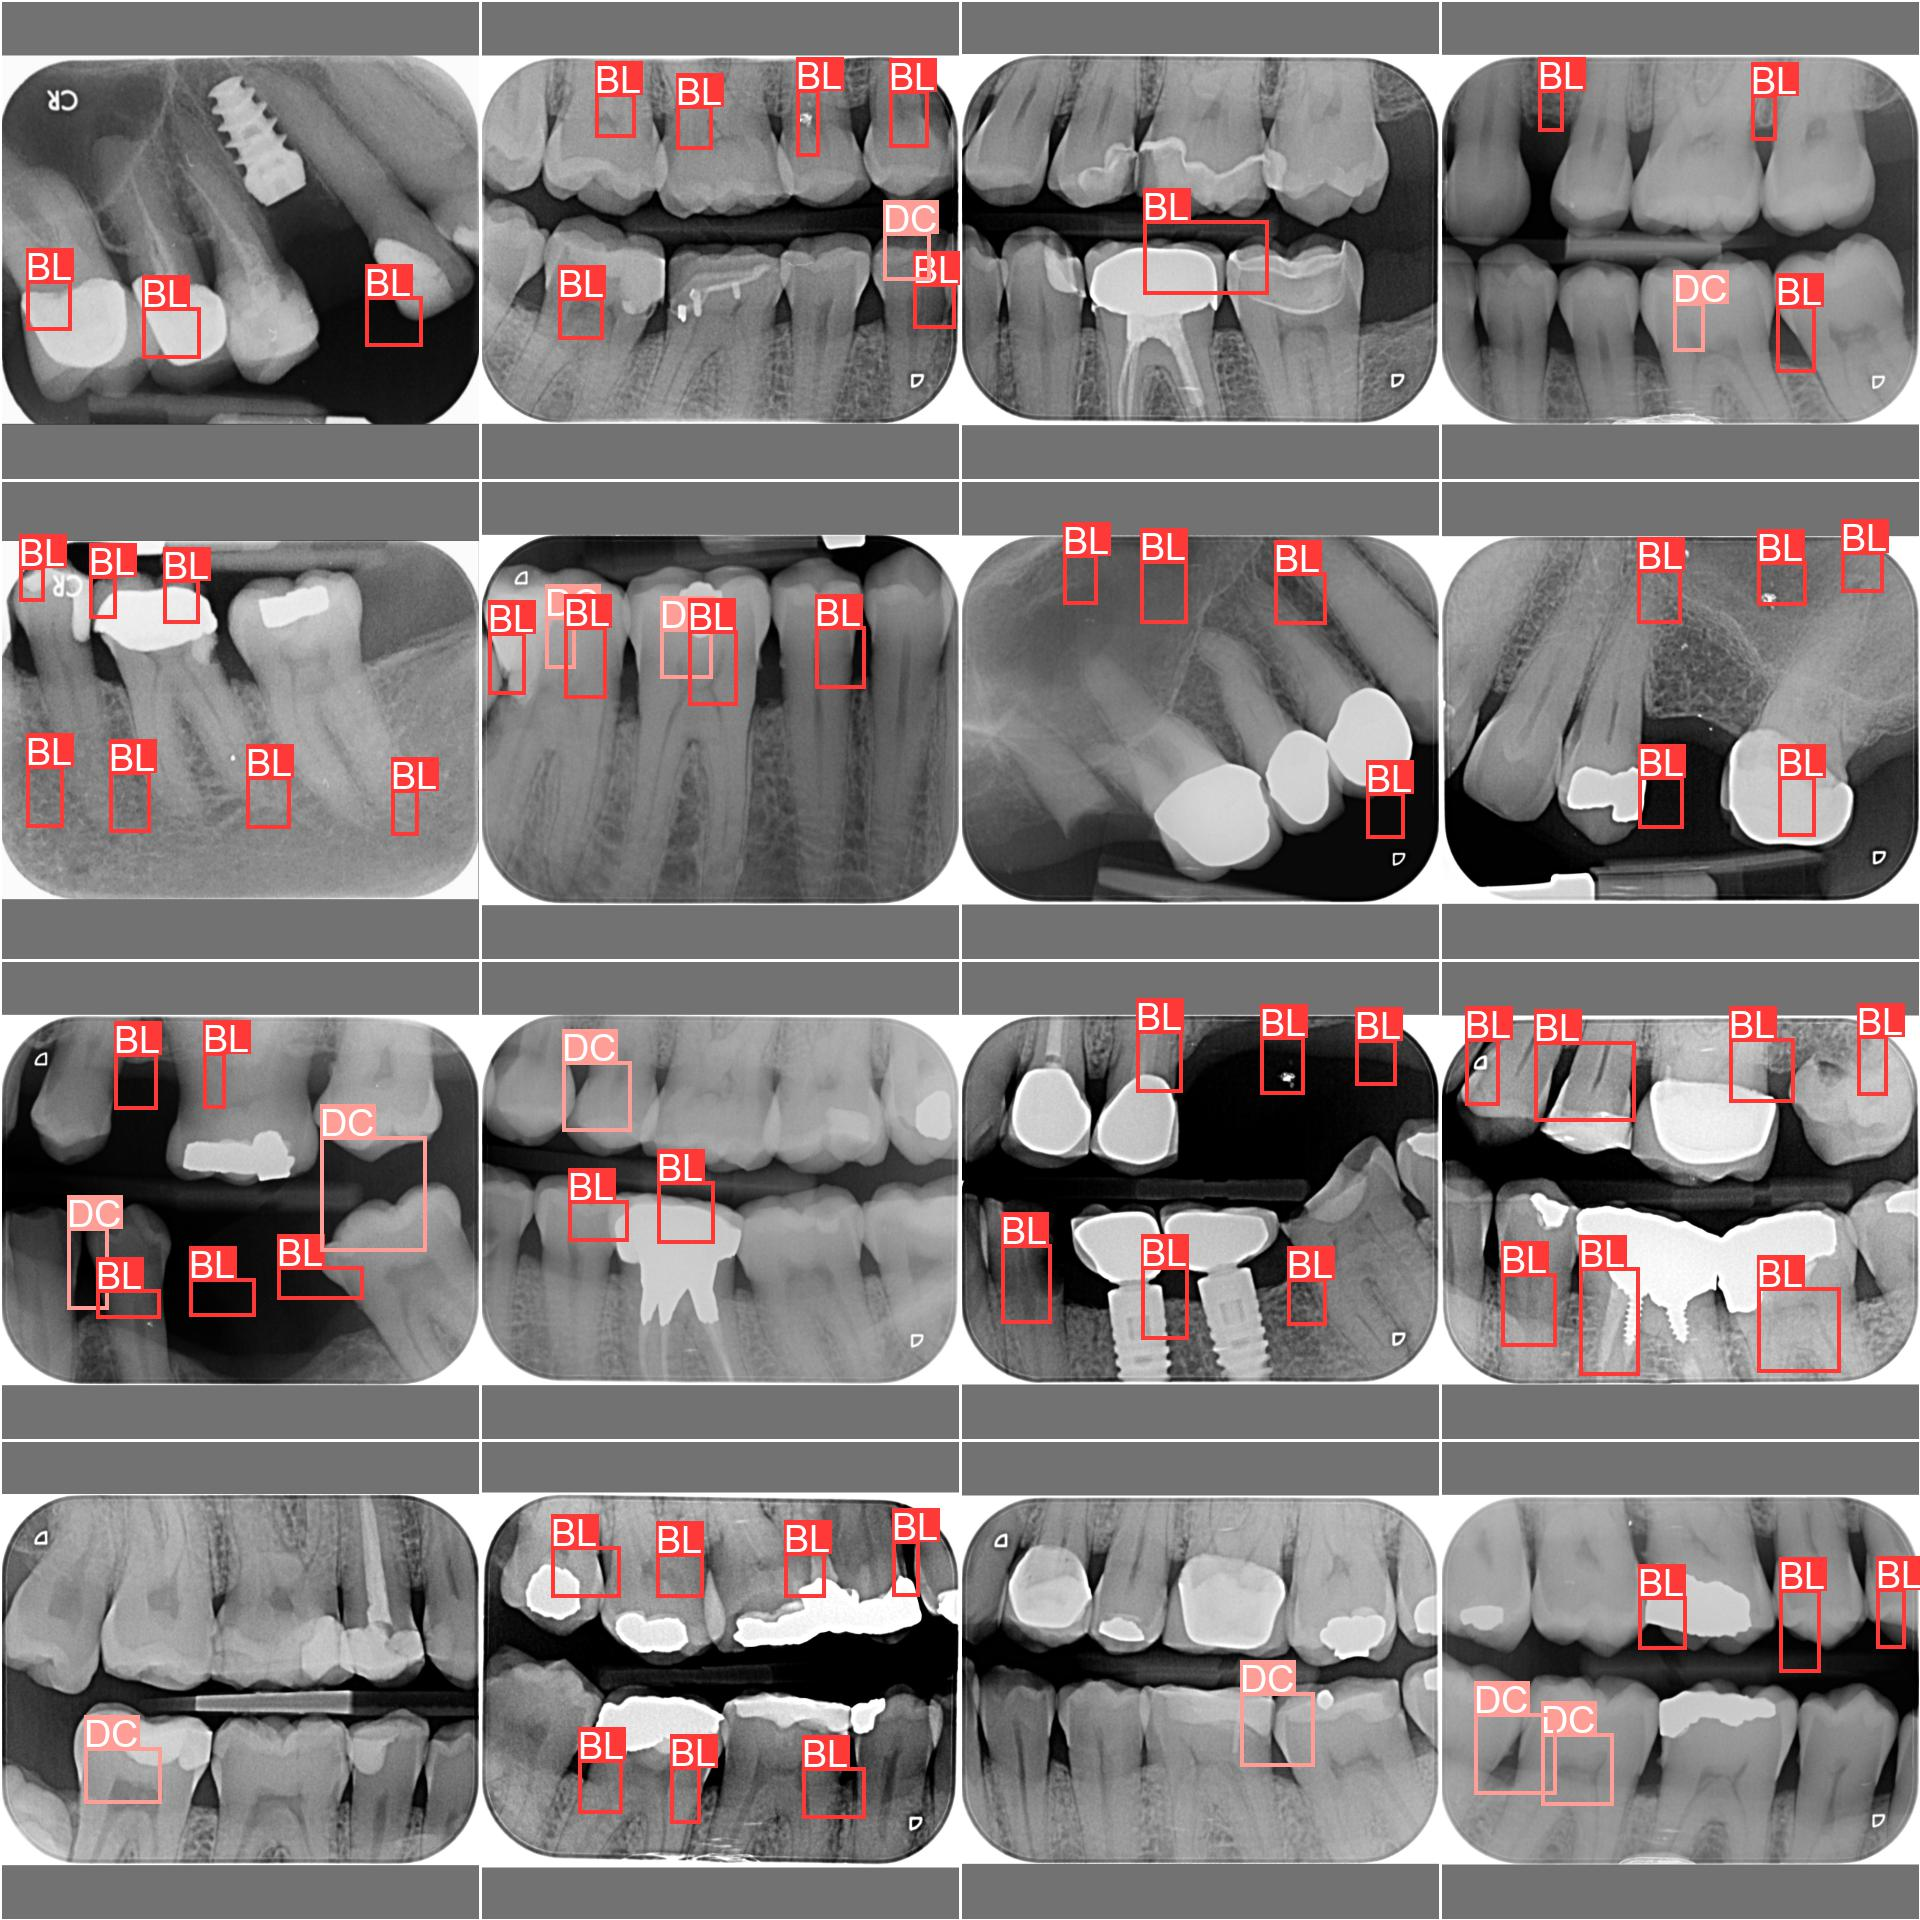

In [182]:
num_cl = 2
num_vol = 4
class_name = {0: 'BL', 1: 'DC'}

plot_images(imgs, img_info_map['expert_labels'], names = ['BL', 'DC'])
pil_img = Image(filename='images.jpg')
display(pil_img)

## YOLO labels (TODO: fix the boxes -- normalize)

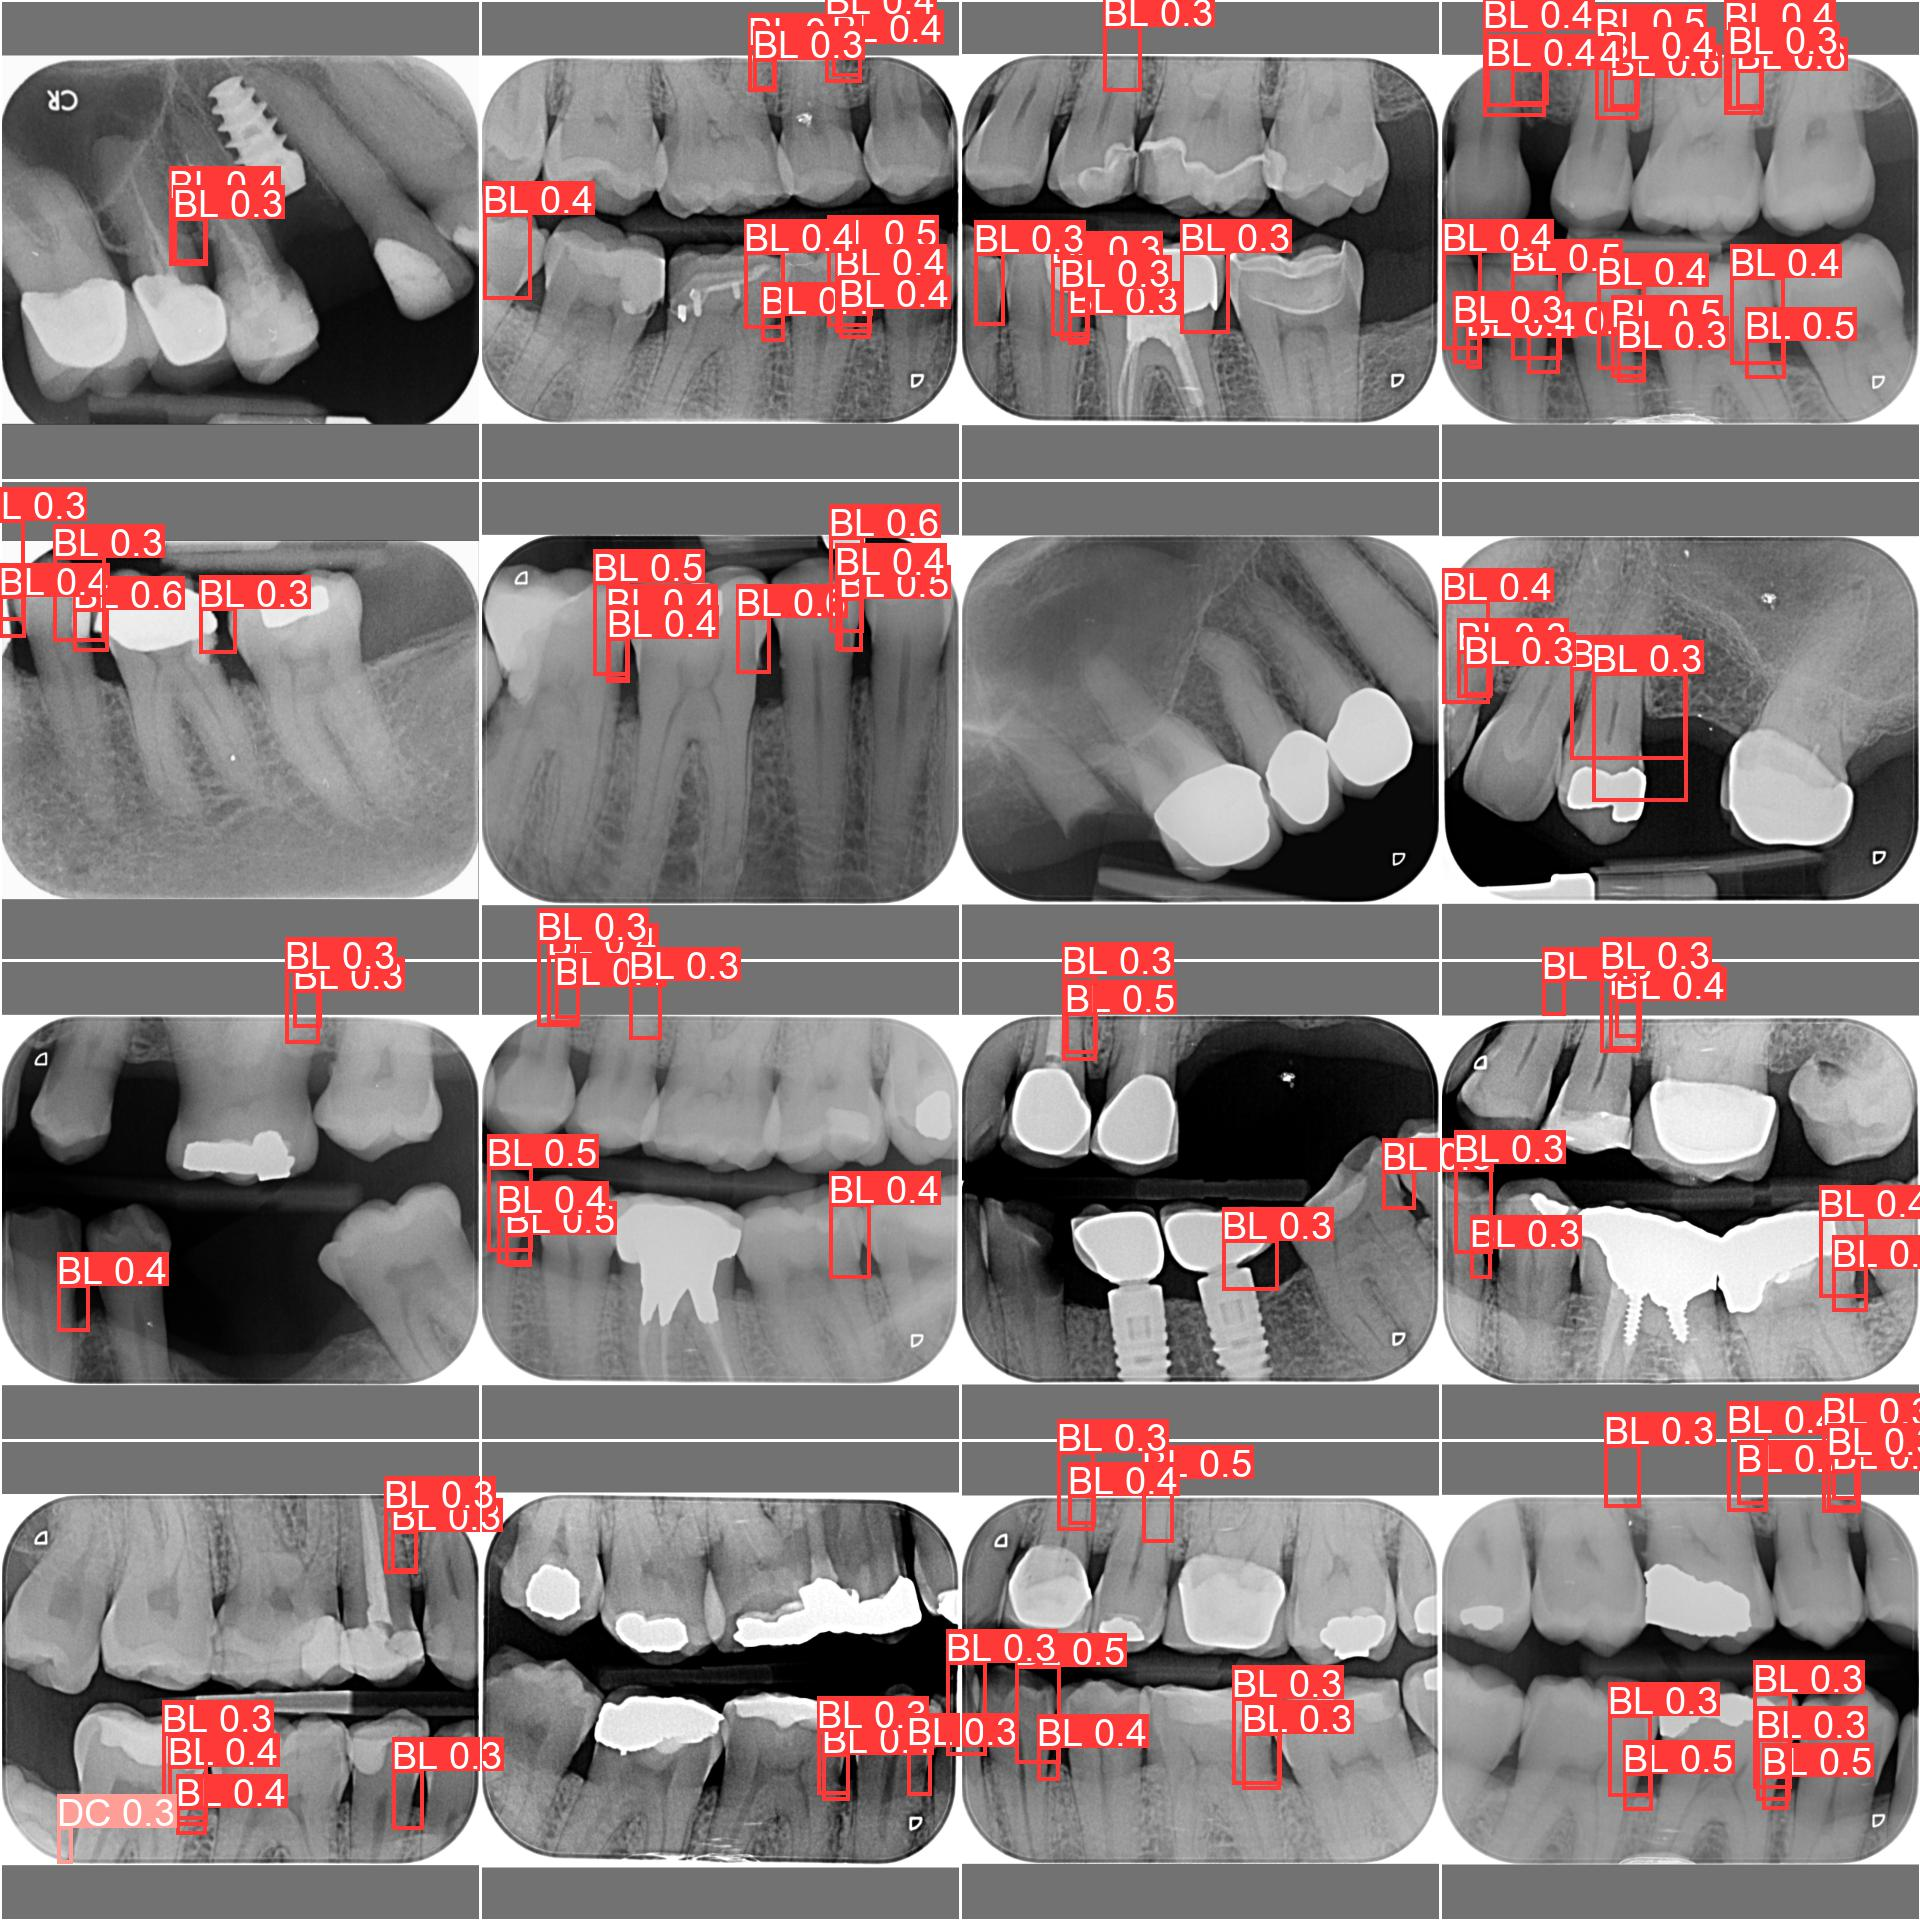

In [207]:
num_cl = 2
num_vol = 4
class_name = {0: 'BL', 1: 'DC'}

plot_images(imgs, img_info_map['yolo_labels'], names = ['BL', 'DC'])
pil_img = Image(filename='images.jpg')
display(pil_img)

In [208]:
experiments = {'YOLO-300': 151,
               'YOLO-450': 194,
               'YOLO-150': 195,
               'CYOLO-300': 197,
               'CYOLO-pt150-300': [195, 196],
               'CYOLO-pt450-450': [194, 198],
               'CYOLO-ptb150-300': [195, 199]
              }

exp_name = 'YOLO-450'
yolo_results = read_exp_results(experiments[exp_name])
yolo_results, yolo_hyp, yolo_opt, yolo_pred = [yolo_results[x] for x in ['results', 'hyp', 'opt', 'pred']]

In [209]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

yolo_results.columns = [x.strip() for x in yolo_results.columns]
yolo_results['train_loss'] = yolo_results[['train/box_loss', 'train/cls_loss', 'train/cls_loss']].sum(axis=1)
yolo_results['val_loss'] = yolo_results[['val/box_loss', 'val/cls_loss', 'val/cls_loss']].sum(axis=1)

In [210]:
yolo_results.columns

Index(['epoch', 'train/box_loss', 'train/obj_loss', 'train/cls_loss',
       'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5',
       'metrics/mAP_0.5:0.95', 'val/box_loss', 'val/obj_loss', 'val/cls_loss',
       'x/lr0', 'x/lr1', 'x/lr2', 'train_loss', 'val_loss'],
      dtype='object')

In [211]:
yolo_results['metrics/precision']
yolo_results['metrics/recall']
yolo_results['metrics/mAP_0.5']

0      0.000284
1      0.000478
2      0.000308
3      0.000768
4      0.000751
         ...   
445    0.150660
446    0.149250
447    0.147260
448    0.146160
449    0.142760
Name: metrics/mAP_0.5, Length: 450, dtype: float64

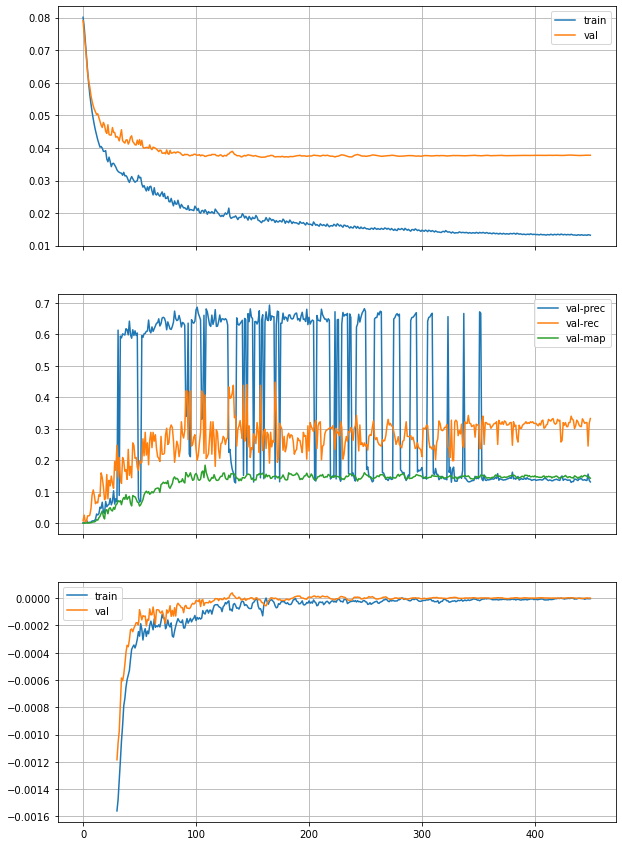

In [213]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
ax = axs[0]
ax.plot(yolo_results['epoch'], yolo_results['train_loss'], label='train')
ax.plot(yolo_results['epoch'], yolo_results['val_loss'], label='val')
# ax.set_xlim(0, 130)
ax.grid()
ax.legend()

ax = axs[1]
ax.plot(yolo_results['epoch'], yolo_results['metrics/precision'], label='val-prec')
ax.plot(yolo_results['epoch'], yolo_results['metrics/recall'], label='val-rec')
ax.plot(yolo_results['epoch'], yolo_results['metrics/mAP_0.5'], label='val-map')
ax.grid()
ax.legend()

ax = axs[2]
ax.plot(yolo_results['epoch'], yolo_results['train_loss'].diff().rolling(30).mean(), label='train')
ax.plot(yolo_results['epoch'], yolo_results['val_loss'].diff().rolling(30).mean(), label='val')
ax.grid()
# ax.set_ylim(-5e-5, 5e-5)
# ax.set_xlim(0, 130)
ax.legend()

## CYOLO labels (TODO: fix the boxes -- normalize)

In [ ]:
import cv2
im_name = 
h, w, _ = cv2.imread('data/src/lena.jpg').shape

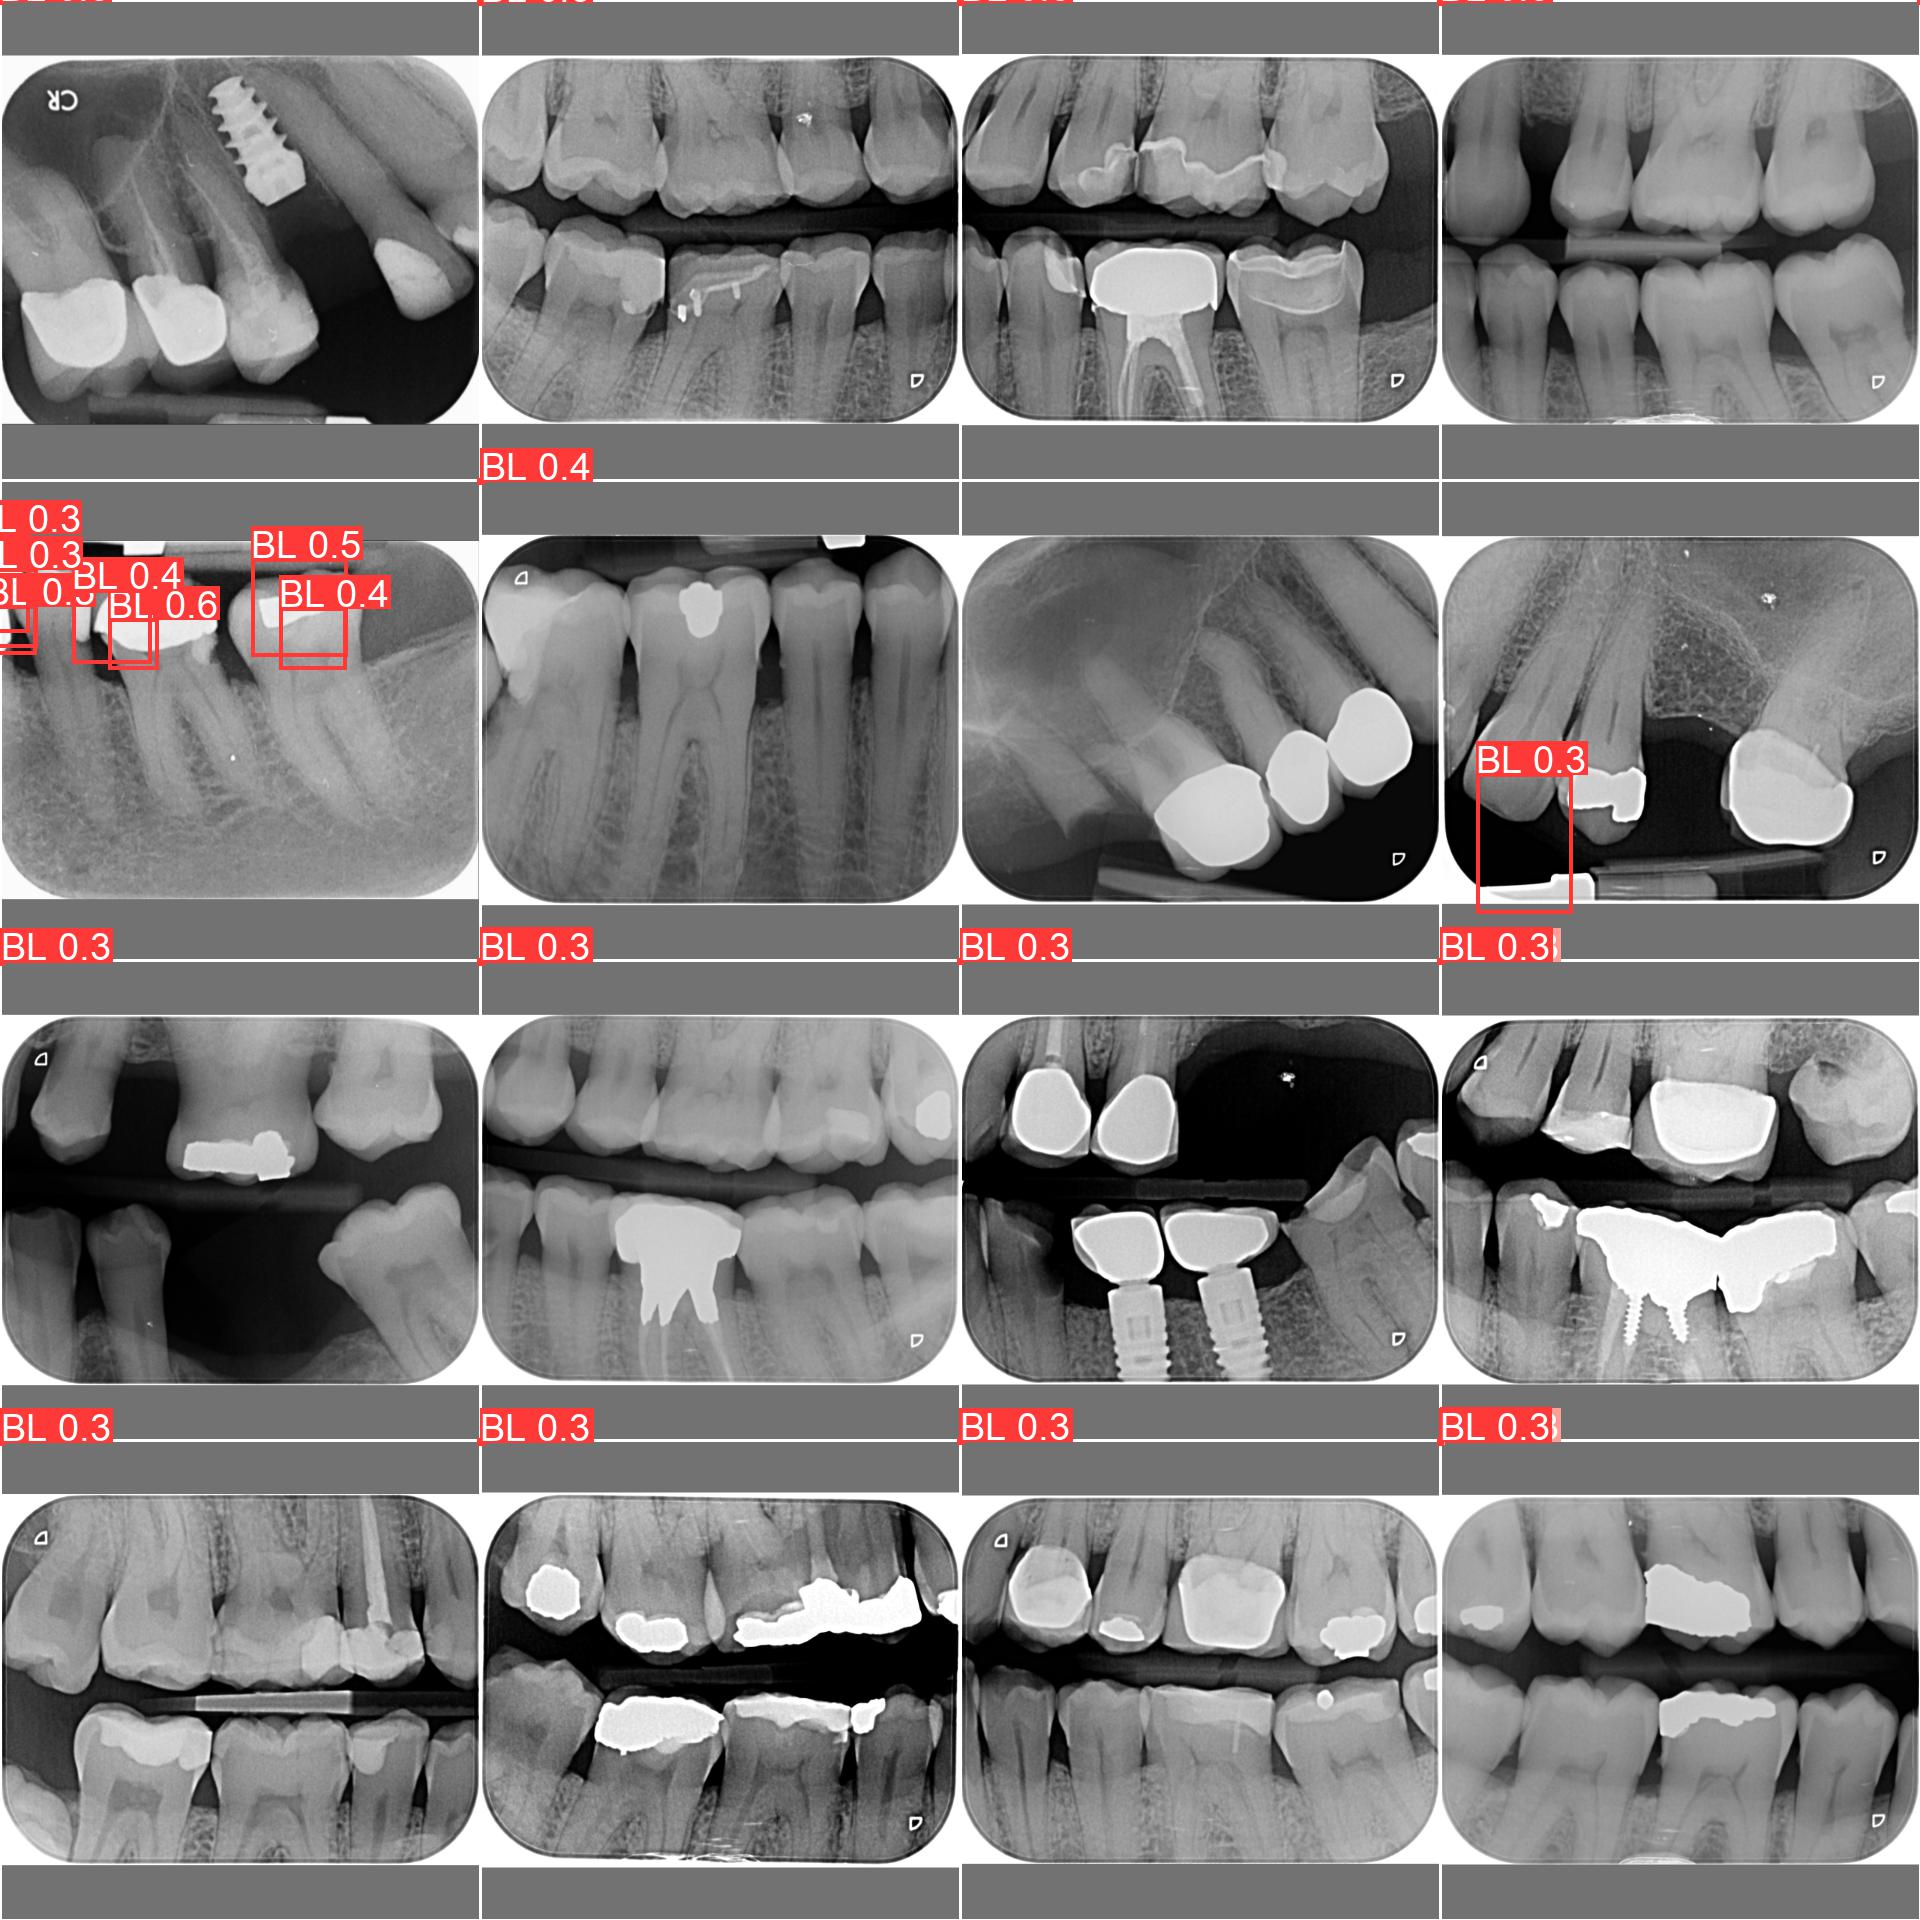

In [93]:
num_cl = 2
num_vol = 4
class_name = {0: 'BL', 1: 'DC'}

plot_images(imgs, img_info_map['cyolo_labels'], names = ['BL', 'DC'])
pil_img = Image(filename='images.jpg')
display(pil_img)

In [163]:
cyolo_results = read_exp_results(experiments['CYOLO-ptb150-300'][-1])
cyolo_results, cyolo_hyp, cyolo_opt, cyolo_pred = [cyolo_results[x] for x in ['results', 'hyp', 'opt', 'pred']]

In [164]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

cyolo_results.columns = [x.strip() for x in cyolo_results.columns]
cyolo_results['train_loss'] = cyolo_results[['train/box_loss', 'train/cls_loss', 'train/cls_loss']].sum(axis=1)
cyolo_results['val_loss'] = cyolo_results[['val/box_loss', 'val/cls_loss', 'val/cls_loss']].sum(axis=1)

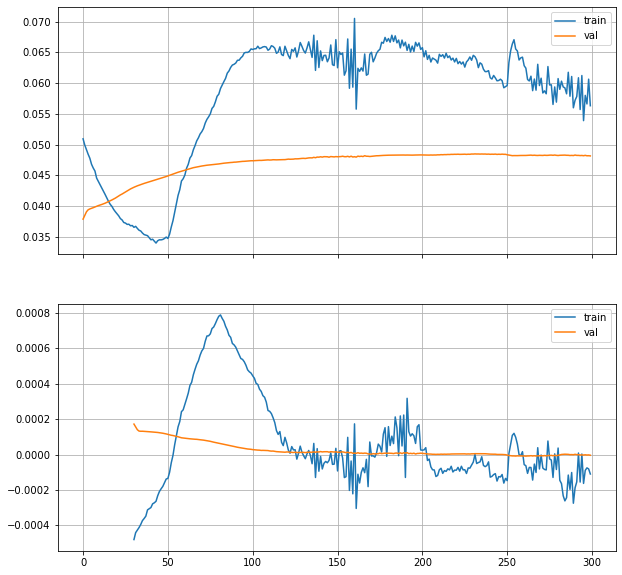

In [165]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax = axs[0]
ax.plot(cyolo_results['epoch'], cyolo_results['train_loss'], label='train')
ax.plot(cyolo_results['epoch'], cyolo_results['val_loss'], label='val')
ax.grid()
ax.legend()

ax = axs[1]
ax.plot(cyolo_results['epoch'], cyolo_results['train_loss'].diff().rolling(30).mean(), label='train')
ax.plot(cyolo_results['epoch'], cyolo_results['val_loss'].diff().rolling(30).mean(), label='val')
ax.grid()
# ax.set_ylim(-5e-5, 5e-5)
ax.legend()

In [160]:
print(df_exp191.columns[0])

NameError: name 'df_exp191' is not defined

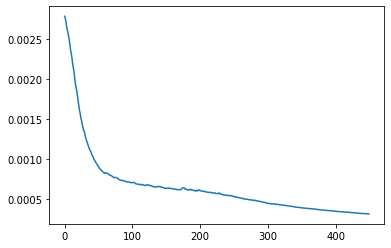

In [62]:
plt.plot(df_exp191[df_exp191.columns[0]], df_exp191[df_exp191.columns[3]])

<Figure size 36000x10800 with 0 Axes>

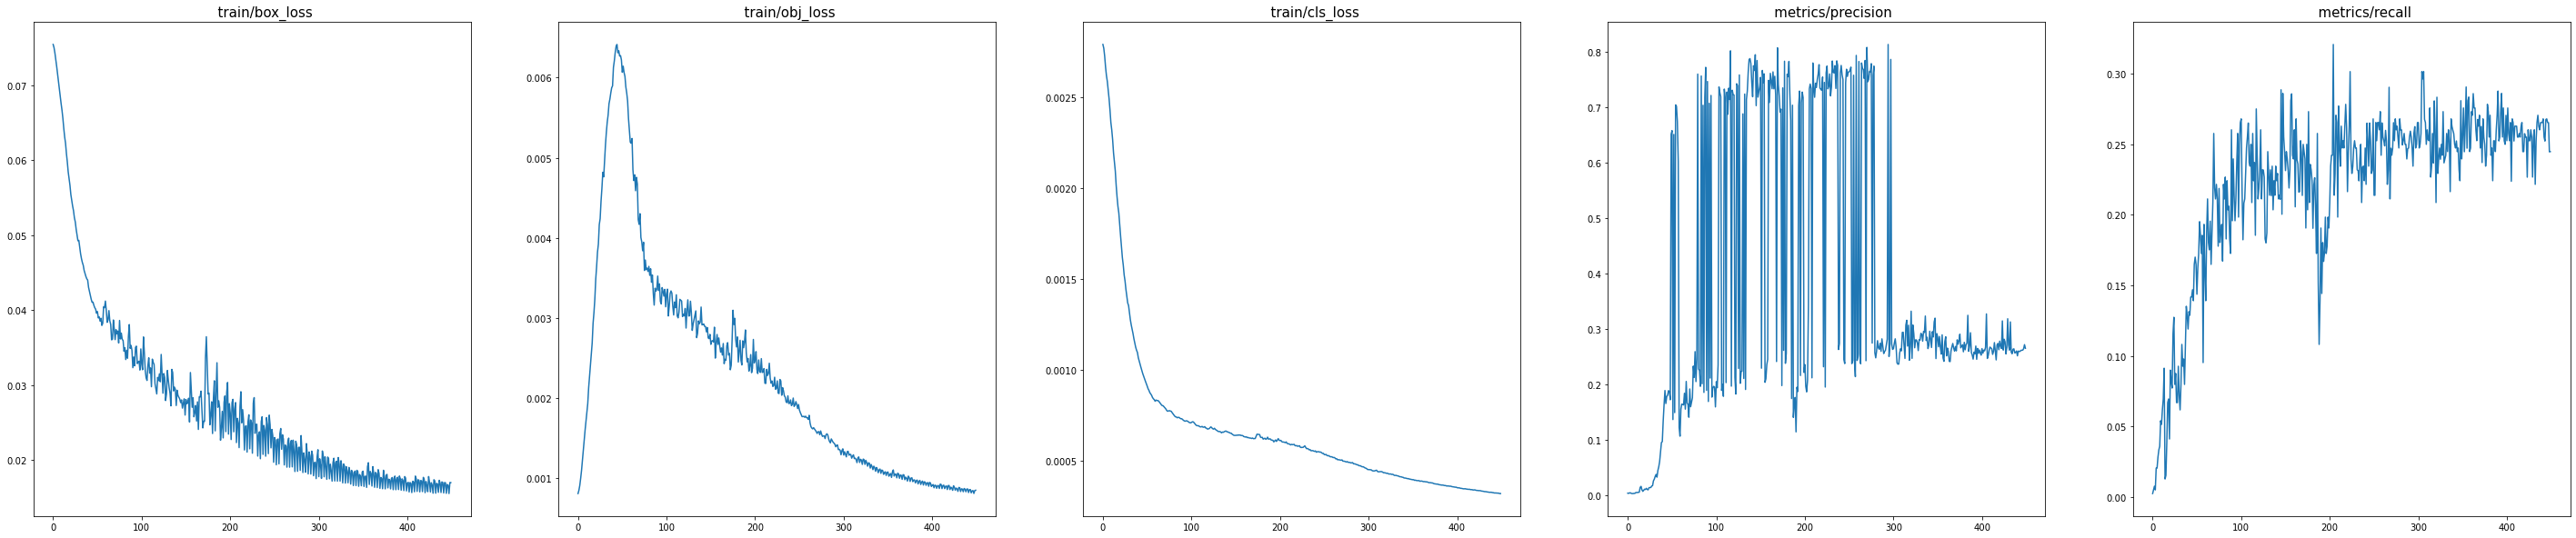

In [75]:
plt.figure(figsize=(500,150))
figure, axis = plt.subplots(1, 5, figsize = (50,10))
for i in range(5):
    axis[i].plot(df_exp191[df_exp191.columns[0]], df_exp191[df_exp191.columns[i+1]])
    axis[i].set_title(df_exp191.columns[i+1], fontsize = 15)
    


In [26]:
df_exp191.iloc[:,0]

0        0
1        1
2        2
3        3
4        4
      ... 
445    445
446    446
447    447
448    448
449    449
Name:                epoch, Length: 450, dtype: int64

In [ ]:
plt.figure(figsize=(600,600))

figure, axis = plt.subplots(2, 5, figsize = (20,10))

axis[0, 0].plot(df_exp102['               epoch'], df_exp102['      train/box_loss'], color='r', label='YOLO w/0 finetune')
axis[0, 0].plot(df_exp112['               epoch'], df_exp112['      train/box_loss'], color='g', label='YOLO w/ finetune')
axis[0, 0].set_title("train/box_loss", fontsize = 15)

plt.legend(bbox_to_anchor=(1.5, 1.5), loc='upper left')
figure.suptitle('YOLO baseline models comparsion', fontsize = 20)

plt.legend(prop={"size":12})
plt.show()